#Fraud Detection with Deep Learning

### Imports

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

### Loading data

In [ ]:
df = pd.read_csv("fraud.csv")
df.head()

,transaction_id,customer_id,amount,time,location,is_fraud
0,TRANS_1668,CUST_257,3871.09,10,Loja Física,0
1,TRANS_731,CUST_391,4222.56,23,Online,1
2,TRANS_1644,CUST_360,4451.62,20,Online,0
3,TRANS_499,CUST_342,2698.11,4,Online,0
4,TRANS_827,CUST_146,2305.39,2,Online,0


In [ ]:
# Number of records
print(f'The number of records in the dataset is: {df.shape[0]}')

The number of records in the dataset is: 3784


In [ ]:
# Number of attributes
print(f'The number of attributes in the dataset is: {df.shape[1]}')

The number of attributes in the dataset is: 6


# **EDA**

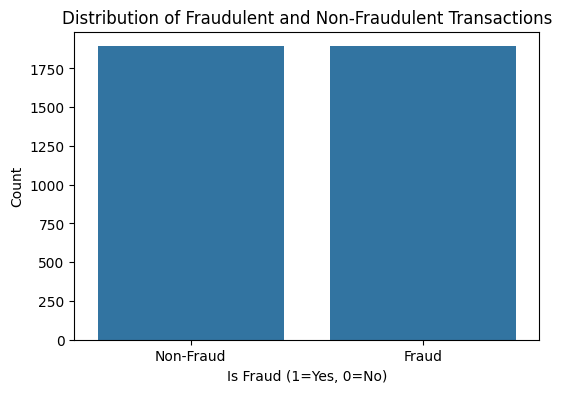

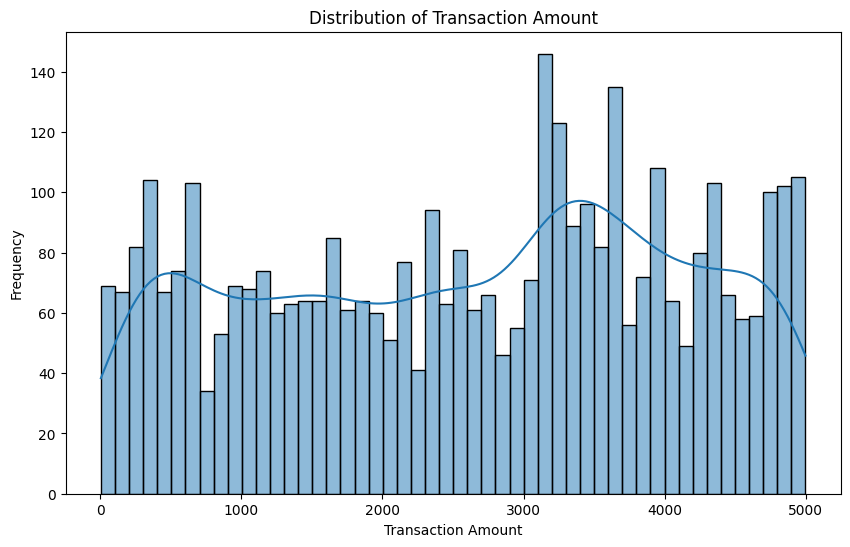

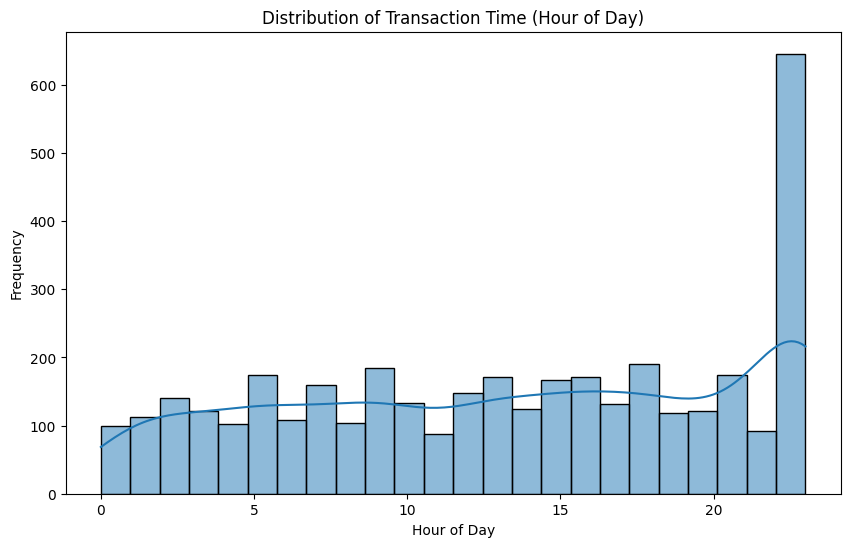

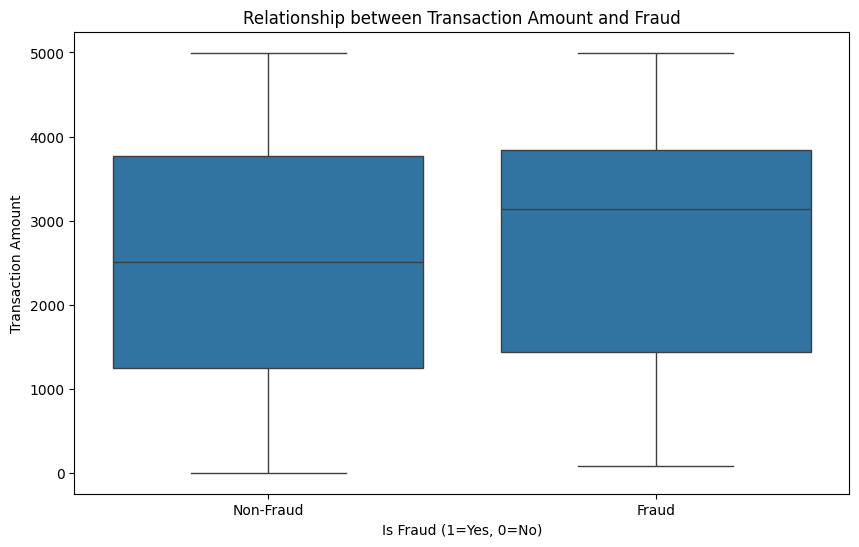

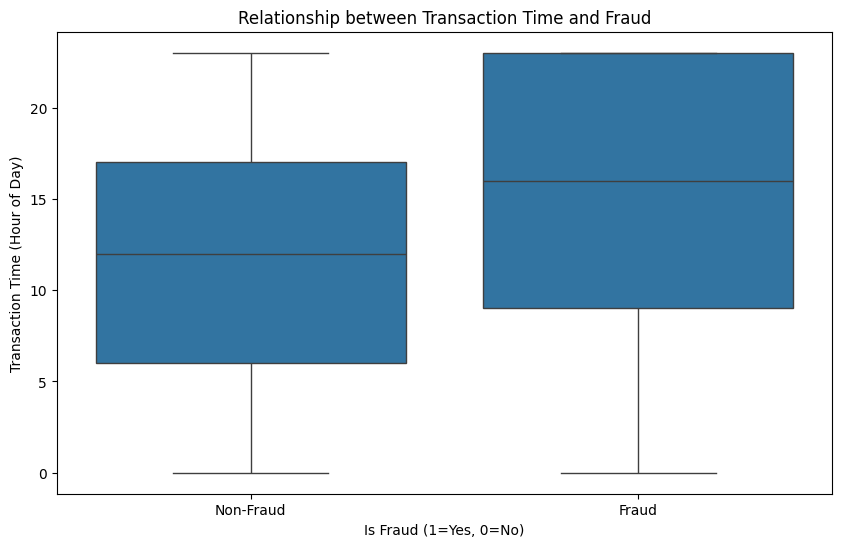

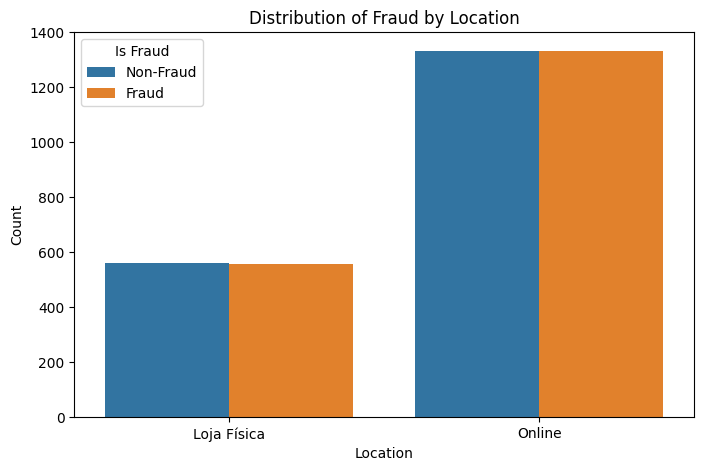

In [ ]:
# Distribution of the target variable (is_fraud)
plt.figure(figsize=(6, 4))
sns.countplot(x='is_fraud', data=df)
plt.title('Distribution of Fraudulent and Non-Fraudulent Transactions')
plt.xlabel('Is Fraud (1=Yes, 0=No)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.show()

# Distribution of transaction amount
plt.figure(figsize=(10, 6))
sns.histplot(df['amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amount')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

# Distribution of transaction time
plt.figure(figsize=(10, 6))
sns.histplot(df['time'], bins=24, kde=True)
plt.title('Distribution of Transaction Time (Hour of Day)')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.show()

# Relationship between transaction amount and fraud (Box Plot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_fraud', y='amount', data=df)
plt.title('Relationship between Transaction Amount and Fraud')
plt.xlabel('Is Fraud (1=Yes, 0=No)')
plt.ylabel('Transaction Amount')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.show()

# Relationship between transaction time and fraud (Box Plot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_fraud', y='time', data=df)
plt.title('Relationship between Transaction Time and Fraud')
plt.xlabel('Is Fraud (1=Yes, 0=No)')
plt.ylabel('Transaction Time (Hour of Day)')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.show()

# Distribution of location by fraud
plt.figure(figsize=(8, 5))
sns.countplot(x='location', hue='is_fraud', data=df)
plt.title('Distribution of Fraud by Location')
plt.xlabel('Location')
plt.ylabel('Count')
plt.legend(title='Is Fraud', labels=['Non-Fraud', 'Fraud'])
plt.show()

#Missing values

In [ ]:
# Checking for missing values
df.isnull().sum()

,0
transaction_id,0
customer_id,0
amount,0
time,0
location,0
is_fraud,0


### Preprocessing

In [ ]:
# Remove columns without semantic value
df = df.drop(columns=['transaction_id', 'customer_id'])

# Preprocess Categorical Variables
df_encoded = pd.get_dummies(df, columns=['location'], drop_first=True)

# Separate features (X) and target (y)
X = df_encoded.drop(columns=['is_fraud'])
y = df_encoded['is_fraud']

# Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize (applying fit only on train and transforming train and test)
scaler = StandardScaler()
X_train[['amount', 'time']] = scaler.fit_transform(X_train[['amount', 'time']])
X_test[['amount', 'time']] = scaler.transform(X_test[['amount', 'time']])

#MLP Neural Network with hyperparameter tuning



Best hyperparameters: {'activation': 'relu', 'alpha': np.float64(0.0016738085788752138), 'batch_size': 64, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'adaptive', 'learning_rate_init': np.float64(0.004660699842170359), 'solver': 'adam'}

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       363
           1       0.82      0.87      0.85       394

    accuracy                           0.83       757
   macro avg       0.84      0.83      0.83       757
weighted avg       0.84      0.83      0.83       757


Confusion Matrix:


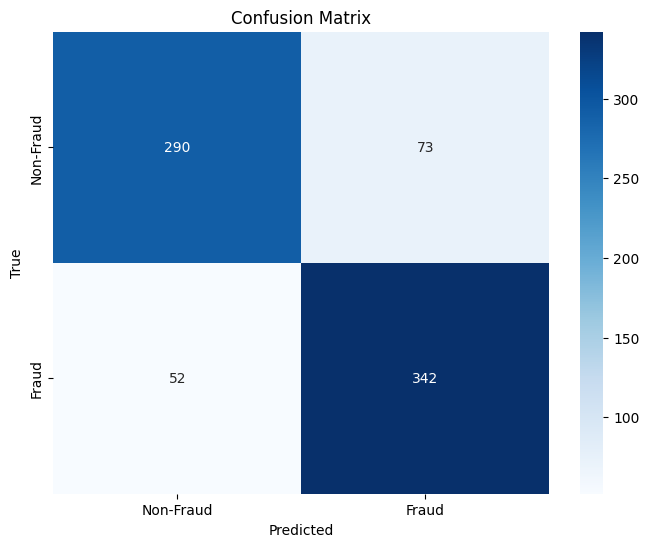

In [ ]:
# Define the model
mlp = MLPClassifier(max_iter=500, random_state=42)

# Define hyperparameters for tuning
param_distributions = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],  # Sizes of the neural network hidden layers
    'activation': ['relu', 'tanh'],                    # Activation function used in neurons
    'solver': ['adam', 'sgd'],                                   # Optimization algorithm used to train the network
    'alpha': reciprocal(1e-4, 1e-2),                              # L2 regularization parameter (overfitting control)
    'learning_rate': ['constant', 'invscaling', 'adaptive'],     # Learning rate adjustment strategy
    'learning_rate_init': uniform(0.0001, 0.01),                 # Initial learning rate value
    'batch_size': [32, 64, 128]                                  # Batch size used in training
}

# Configure randomized search
random_search = RandomizedSearchCV(mlp, param_distributions, n_iter=10, cv=3, random_state=42, n_jobs=-1)

# Perform hyperparameter tuning
random_search.fit(X_train, y_train)

# Best hyperparameters found
print("Best hyperparameters:", random_search.best_params_)

# Best model found
best_mlp = random_search.best_estimator_

# Predictions on the test set
y_pred = best_mlp.predict(X_test)

# Model evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Financial Impact of the model

In [ ]:
# Assuming an average transaction value to estimate the cost of false positives and savings
# You can adjust this based on your domain knowledge or data analysis
average_transaction_amount = df['amount'].mean()

# Get values from the confusion matrix
# True Negatives (TN), False Positives (FP), False Negatives (FN), True Positives (TP)
tn, fp, fn, tp = cm.ravel()

# Calculate the cost of false positives
# Each false positive is a legitimate transaction incorrectly flagged as fraud, potentially leading to customer inconvenience and loss of business.
# We estimate this cost by multiplying the number of false positives by the average transaction amount.
cost_of_false_positives = fp * average_transaction_amount

# Calculate savings from correctly identified frauds (True Positives)
# Each true positive is a fraudulent transaction correctly identified, preventing financial losses.
# We estimate these savings by multiplying the number of true positives by the average transaction amount.
savings_from_true_positives = tp * average_transaction_amount

# Calculate the net monetary impact
net_monetary_impact = savings_from_true_positives - cost_of_false_positives

print(f"\nModel Economic Impact:")
print(f"Cost of False Positives: R$ {cost_of_false_positives:,.2f}")
print(f"Savings from True Positives: R$ {savings_from_true_positives:,.2f}")
print(f"Net Monetary Impact: R$ {net_monetary_impact:,.2f}")


Model Economic Impact:
Cost of False Positives: R$ 190,892.43
Savings from True Positives: R$ 894,317.94
Net Monetary Impact: R$ 703,425.52
